In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def buildManyToManyModel1(shape):
    model = Sequential()
    model.add(LSTM(32, input_length=shape[1], input_dim=shape[2], return_sequences=True))
    # output shape: (5, 1)
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

In [3]:
def buildTrain(train, pastDay=30, futureDay=5):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Close"]))
    return np.array(X_train), np.array(Y_train)

In [4]:
def splitData(X,Y,v_length=200):
    X_val = X[X.shape[0] - v_length:]
    Y_val = Y[Y.shape[0] - v_length:]
    X_train = X[:X.shape[0] - v_length]
    Y_train = Y[:Y.shape[0] - v_length]
    return X_train, Y_train, X_val, Y_val

In [5]:
def readTrain():
    stock_name='^TWSE'
    df = web.DataReader(stock_name, 'stooq')
    df = df.sort_index(ascending=True, axis=0)

    train = df
    print(df.head())
    df['Close'].plot()
    plt.show()
    return train

In [6]:
def normalize(train):
    #train = train.drop(["Date"], axis=1)
    train = train.drop(["Volume"], axis=1)
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

               Open     High      Low    Close  Volume
Date                                                  
1995-01-05  7129.94  7144.70  7040.72  7051.49     NaN
1995-01-06  7086.88  7086.88  6884.61  6919.31     NaN
1995-01-07  6948.27  6948.27  6855.55  6915.40     NaN
1995-01-09  6948.73  6959.74  6869.08  6869.08     NaN
1995-01-10  6817.85  6838.95  6706.67  6756.88     NaN


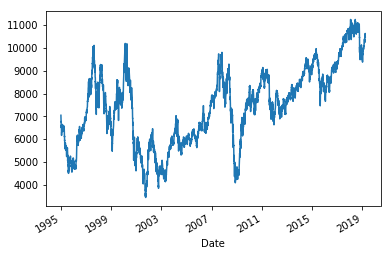

                Open      High       Low     Close
Date                                              
1995-01-05 -0.040471 -0.043823 -0.044805 -0.048939
1995-01-06 -0.046015 -0.051276 -0.064845 -0.065871
1995-01-07 -0.063859 -0.069140 -0.068575 -0.066372
1995-01-09 -0.063800 -0.067662 -0.066839 -0.072305
1995-01-10 -0.080649 -0.083230 -0.087688 -0.086677


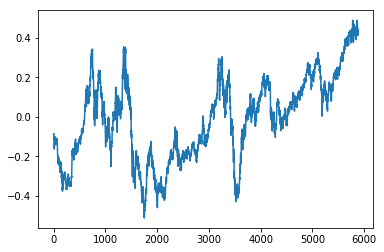

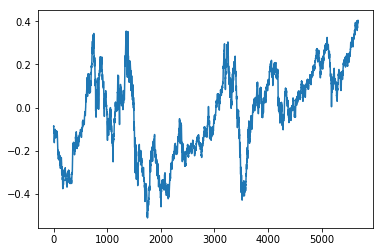

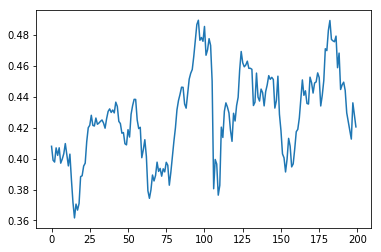

In [7]:
train = readTrain()
train_norm = normalize(train)
print(train_norm.head())
# change the last day and next day 
X_train0, Y_train0 = buildTrain(train_norm, 90, 90)

X_train, Y_train, X_val, Y_val = splitData(X_train0, Y_train0)
plt.plot(X_train0[:,4,3])
plt.show()
plt.plot(X_train[:,4,3])
plt.show()
plt.plot(X_val[:,4,3])
plt.show()
# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]


In [8]:

model = buildManyToManyModel1(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, return_sequences=True, input_shape=(90, 4))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 90, 32)            4736      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 1)             33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
Train on 5681 samples, validate on 200 samples
Epoch 1/1000
5681/5681 [==============================] - 6s 1ms/step - loss: 0.0200 - val_loss: 0.0144
Epoch 2/1000
5681/5681 [==============================] - 5s 942us/step - loss: 0.0160 - val_loss: 0.0105
Epoch 3/1000
5681/5681 [==============================] - 5s 825us/step - loss: 0.0158 - val_loss: 0.0104
Epoch 4/1000
5681/5681 [==============================] - 5s 910us/step - loss: 0.0156 - val_loss: 0.0082
Epoch 5/1000
5681/5681 [==============================] - 5s 903us/

In [12]:
ret = model.predict(X_train0[1000:])

(6061, 4)
(4881, 90, 1)
(5681, 90, 4)
(5681, 90, 1)
(200, 90, 4)


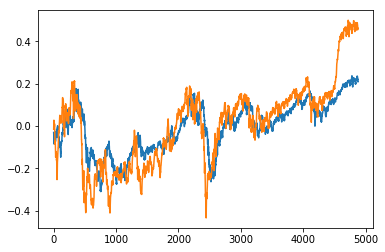

In [13]:
print(train_norm.shape)
print(ret.shape)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
plt.plot(ret[:,0,0])
plt.plot(ret[:,59,0])
plt.show()

In [11]:
ret.shape

(2881, 90, 1)